# Scrambling of operators

In [1]:
using Pkg
Pkg.instantiate()
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra

In [27]:
N  = 21    # Number of spins
J  = 1.0    # ZZ interaction strength
hx = 1.05   # X-field 
hz = 0.5    # Z-field
δt = 0.05   # Time-step for evolution
β = 0.1    # 1/temp
δβ = β/200   # temp step
T  = 10.0 # Total time
χ  = 32   # Max link dimension allowed
# hx = 0.0   # X-field 
# hz = 0.0
# Δ = 0.05
 

32

## System

In [28]:
sites = siteinds("S=1/2",N);      # Make N S=1/2 spin indices defining system

In [29]:
# Define mixed-field Ising Hamiltionian operator terms:

H_op = OpSum()
for i=1:N-1
    H_op += 1.0,"Sz",i,"Sz",i+1 # ZZ terms
end
for i=1:N
    H_op += hx,"Sx",i         # X terms
    H_op += hz,"Sz",i         # Z terms
end

# E = 3*J
# for i=1:2*(N-1)

#     H_op += (-1)^(i-1) * J/E,"Sx",i,"Sx",i+2
#     H_op += (-1)^(i-1) * J/E,"Sy",i,"Sy",i+2
#     H_op += (-1)^(i-1) * J/E, Δ, "Sz",i,"Sz",i+2
# end

# Convert these terms to an MPO
H = MPO(H_op,sites);

In [30]:
# Perform DMRG to find the ground state:

ψ0 = randomMPS(sites,2)               # Random initial state
sweeps = Sweeps(10)                   # Number of sweeps is 10  
maxdim!(sweeps,10,20,100,100,200)     # Gradually increase states kept
cutoff!(sweeps,1E-10)                 # Desired truncation error
en_min,ψ_gs = dmrg(H,ψ0,sweeps);      # Find the ground state energy 

After sweep 1 energy=-12.187051157133377  maxlinkdim=8 maxerr=2.15E-16 time=0.168


After sweep 2 energy=-12.193512868678434  maxlinkdim=10 maxerr=9.54E-11 time=0.081


After sweep 3 energy=-12.19351344696084  maxlinkdim=5 maxerr=8.66E-11 time=0.097


After sweep 4 energy=-12.19351344696324  maxlinkdim=5 maxerr=4.49E-12 time=0.062


After sweep 5 energy=-12.19351344696327  maxlinkdim=5 maxerr=4.48E-12 time=0.093


After sweep 6 energy=-12.193513446963262  maxlinkdim=5 maxerr=4.48E-12 time=0.100


After sweep 7 energy=-12.193513446963255  maxlinkdim=5 maxerr=4.48E-12 time=0.073


After sweep 8 energy=-12.193513446963244  maxlinkdim=5 maxerr=4.48E-12 time=0.082


After sweep 9 energy=-12.193513446963243  maxlinkdim=5 maxerr=4.48E-12 time=0.064


After sweep 10 energy=-12.193513446963266  maxlinkdim=5 maxerr=4.48E-12 time=0.081


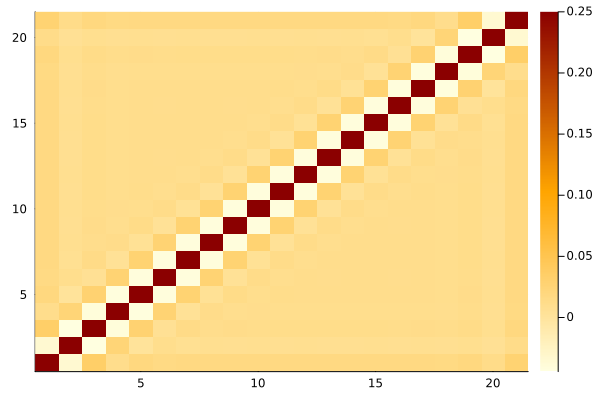

In [31]:
zzcorr = correlation_matrix(ψ_gs,"Sz","Sz");
gr()
heatmap(1:N, 1:N, zzcorr, c = :heat)

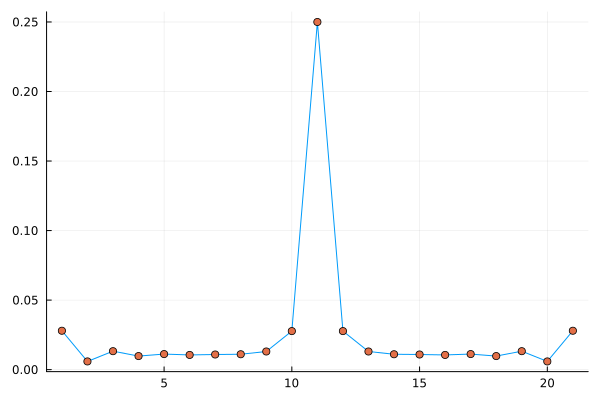

In [32]:
zzcen = diag(reverse(zzcorr, dims = 2));
plot(1:N, zzcen, label=false)  
scatter!(1:N, zzcen, label=false) 

## Extended system + ancilla

In [33]:
sitesext = siteinds("S=1/2",2*N); # Make 2N S=1/2 spin indices defining system + ancilla

In [34]:
# Extract the raising, lowering and identity operators for the extended system:

Sp = ops(sitesext, [("S+", n) for n in 1:(2*N)]);  # Raising operators
Sm = ops(sitesext, [("S-", n) for n in 1:(2*N)]);  # Lowering operators
# ITensors doesn't include the identity operator as standard so construct it:
Id = Vector{ITensor}(undef,2*N)
for i =1:(2*N)
    iv = sitesext[i]
    ID = ITensor(iv', dag(iv));
    for j in 1:ITensors.dim(iv)
        ID[iv' => j, iv => j] = 1.0
    end
    Id[i] = ID
end

In [35]:
# Construct the identity vacuum state:

Ivac = MPS(sitesext, "Up") # All up spins initial state
gates = [(Id[n]*Id[n+1] + Sm[n]*Sm[n+1]) for n in 1:2:(2*N)]; # Maps |00> => |00> + |11>
Ivac = apply(gates, Ivac; cutoff=1e-15); # Note we have no 1/sqrt(2) normalisation

In [36]:
# Vectorisation approach used here is to stack matrix rows into a column vector.
# This means that:
# vec(AB) = A ⊗ I vec(B) =  I ⊗ B^T vec(A)
# so |i><j| => |i> ⊗ |j>
# vec(L A R) = L ⊗ R^T vec(A)

# Anticommutator Hamiltonian due to  e^(-βH/2) X_0 e^(-βH/2) operator
# as opposed to e^(-iHt) X_0 e^(iHt)

# HA = H ⊗ I + I ⊗ H, since H is real and hermitian H = H^T

H_op = OpSum()
for i=1:2*(N-1)
    H_op += J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op +=  hx,"Sx",i
    H_op +=  hz,"Sz",i
end


# Convert these terms to an MPO
HA = MPO(H_op,sitesext);

In [37]:
# Define observable for scrambling:
A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, Ivac; cutoff=1e-15);   # Compute |A> = A|I>


function local_op(N,sitesext;r) #function used to define local operator to track C(r,t)
    # requirer < floor(Int, N/2) 
    site_index= 2*floor(Int,N/2+1)+2*r-1 #defining site index
    Sx_r_system= op("Sx", sitesext, site_index)
    Sx_r_ancilla= op("Sx", sitesext, site_index+1)
    
    return Sx_r_system, Sx_r_ancilla
end;



## Perform TDVP time evolution of the operator

In [38]:
# Define function for computing entanglement entropy

function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        p = diag(S).^2               # Extract square of Schmidt coefficients
        p = p ./ sum(p)              # Normalise to a probability dist
        SvN[b] = -sum(p .* log2.(p)) # Compute Shannon entropy
    end
    return SvN
end;

# Define function that calulates the commutator 
function compute_commutator(ψ,Sx_r_system,Sx_r_ancilla)
    Sx_a= apply(Sx_r_system,ψ;cutoff=1e-15)
    a_Sx= apply(Sx_r_ancilla,ψ;cutoff=1e-15)

    return Sx_a - a_Sx
end;

In [39]:
SvN_init = entanglement_entropy(Avec);
#plot(1:(2*N), SvN_init, label=false) ;
;


Here $|A>$ displays the entanglement structure of the initial vacuum state.

In [40]:
# Define observer functions for TDVP:

function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(-im*current_time)
  end
    
  return nothing
end

function measure_SvN(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return (entanglement_entropy(psi)-SvN_init)
  end
  return nothing
end;

function measure_linkdim(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return maxlinkdim(psi)
  end
  return nothing
end;

# function measure_commutator(;psi,bond,half_sweep,Sx_r_system=Sx_5_system,Sx_r_ancilla=Sx_5_ancilla)
#   if bond == 1 && half_sweep == 2
#     return compute_commutator(psi,Sx_r_system,Sx_r_ancilla) 
#   end
#   return nothing
# end;
function measure_commutator(; psi, bond, half_sweep)
  Sx_2_system, Sx_2_ancilla= local_op(N,sitesext;r=2)
  Sx_4_system, Sx_4_ancilla= local_op(N,sitesext;r=4)
  Sx_6_system, Sx_6_ancilla= local_op(N,sitesext;r=6)
  Sx_8_system, Sx_8_ancilla= local_op(N,sitesext;r=8)

  if bond == 1 && half_sweep == 2
    commutator_2 = compute_commutator(psi, Sx_2_system, Sx_2_ancilla)
    commutator_4 = compute_commutator(psi, Sx_4_system, Sx_4_ancilla)
    commutator_6 = compute_commutator(psi, Sx_6_system, Sx_6_ancilla)
    commutator_8 = compute_commutator(psi, Sx_8_system, Sx_8_ancilla)

    return [real.(inner(commutator_2, commutator_2)), real.(inner(commutator_4, commutator_4)),
            real.(inner(commutator_6, commutator_6)), real.(inner(commutator_8, commutator_8))]

  end
  return nothing

end;

;


In [41]:
# Perform TDVP evolution of |A(t)>:

obs = Observer("times" => current_time, "SvN" => measure_SvN, "chi" => measure_linkdim,"Commutator"=>measure_commutator)



# d|A(t)>/dt = i HC |A(t)> so |A(t)> = exp(i t HC)|A(0)> 
ψ_temp = tdvp(HA, β/2, Ivac; 
          time_step = δβ,
          normalize = false,
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1)

# this will be the thermal state, imaginary time evolved to β/2
# Z = tr(ψ_temp)
Z = inner(Ivac, ψ_temp) 

sqrt_ρ = ψ_temp / sqrt(Z)
;


After sweep 1: maxlinkdim=2 maxerr=7.94E-16 current_time=0.0 time=0.26


After sweep 2: maxlinkdim=2 maxerr=1.02E-15 current_time=0.001 time=0.263


After sweep 3: maxlinkdim=2 maxerr=1.09E-15 current_time=0.002 time=0.267


After sweep 4: maxlinkdim=2 maxerr=1.02E-15 current_time=0.002 time=0.269


After sweep 5: maxlinkdim=2 maxerr=1.13E-15 current_time=0.002 time=0.263


After sweep 6: maxlinkdim=2 maxerr=7.88E-16 current_time=0.003 time=0.264


After sweep 7: maxlinkdim=2 maxerr=7.77E-16 current_time=0.004 time=0.266


After sweep 8: maxlinkdim=2 maxerr=9.99E-16 current_time=0.004 time=0.264


After sweep 9: maxlinkdim=2 maxerr=8.87E-16 current_time=0.005 time=0.267


After sweep 10: maxlinkdim=2 maxerr=3.32E-16 current_time=0.005 time=0.269


After sweep 11: maxlinkdim=2 maxerr=4.43E-16 current_time=0.006 time=0.279


After sweep 12: maxlinkdim=2 maxerr=9.06E-16 current_time=0.006 time=0.303


After sweep 13: maxlinkdim=2 maxerr=7.79E-16 current_time=0.007 time=0.285


After sweep 14: maxlinkdim=2 maxerr=8.02E-16 current_time=0.007 time=0.287


After sweep 15: maxlinkdim=2 maxerr=1.12E-15 current_time=0.008 time=0.286


After sweep 16: maxlinkdim=2 maxerr=8.84E-16 current_time=0.008 time=0.288


After sweep 17: maxlinkdim=2 maxerr=5.52E-16 current_time=0.009 time=0.305


After sweep 18: maxlinkdim=2 maxerr=6.63E-16 current_time=0.009 time=0.324


After sweep 19: maxlinkdim=2 maxerr=5.52E-16 current_time=0.01 time=0.312


After sweep 20: maxlinkdim=2 maxerr=6.62E-16 current_time=0.01 time=0.288


After sweep 21: maxlinkdim=2 maxerr=6.61E-16 current_time=0.011 time=0.295


After sweep 22: maxlinkdim=2 maxerr=6.61E-16 current_time=0.011 time=0.287


After sweep 23: maxlinkdim=2 maxerr=7.70E-16 current_time=0.012 time=0.282


After sweep 24: maxlinkdim=2 maxerr=9.90E-16 current_time=0.012 time=0.283


After sweep 25: maxlinkdim=2 maxerr=8.73E-16 current_time=0.013 time=0.298


After sweep 26: maxlinkdim=2 maxerr=1.12E-15 current_time=0.013 time=0.284


After sweep 27: maxlinkdim=2 maxerr=9.87E-16 current_time=0.014 time=0.285


After sweep 28: maxlinkdim=2 maxerr=1.21E-15 current_time=0.014 time=0.288


After sweep 29: maxlinkdim=2 maxerr=1.31E-15 current_time=0.015 time=0.299


After sweep 30: maxlinkdim=2 maxerr=1.31E-15 current_time=0.015 time=0.287


After sweep 31: maxlinkdim=2 maxerr=1.42E-15 current_time=0.016 time=0.283


After sweep 32: maxlinkdim=2 maxerr=1.64E-15 current_time=0.016 time=0.293


After sweep 33: maxlinkdim=2 maxerr=1.74E-15 current_time=0.017 time=0.288


After sweep 34: maxlinkdim=2 maxerr=1.94E-15 current_time=0.017 time=0.301


After sweep 35: maxlinkdim=2 maxerr=2.07E-15 current_time=0.018 time=0.288


After sweep 36: maxlinkdim=2 maxerr=2.28E-15 current_time=0.018 time=0.291


After sweep 37: maxlinkdim=2 maxerr=2.50E-15 current_time=0.019 time=0.283


After sweep 38: maxlinkdim=2 maxerr=2.71E-15 current_time=0.019 time=0.294


After sweep 39: maxlinkdim=2 maxerr=2.86E-15 current_time=0.02 time=0.28


After sweep 40: maxlinkdim=2 maxerr=3.18E-15 current_time=0.02 time=0.277


After sweep 41: maxlinkdim=2 maxerr=3.59E-15 current_time=0.021 time=0.281


After sweep 42: maxlinkdim=2 maxerr=3.83E-15 current_time=0.021 time=0.291


After sweep 43: maxlinkdim=2 maxerr=4.23E-15 current_time=0.022 time=0.278


After sweep 44: maxlinkdim=2 maxerr=4.61E-15 current_time=0.022 time=0.277


After sweep 45: maxlinkdim=2 maxerr=4.92E-15 current_time=0.023 time=0.278


After sweep 46: maxlinkdim=2 maxerr=5.37E-15 current_time=0.023 time=0.295


After sweep 47: maxlinkdim=2 maxerr=5.88E-15 current_time=0.024 time=0.29


After sweep 48: maxlinkdim=2 maxerr=6.33E-15 current_time=0.024 time=0.294


After sweep 49: maxlinkdim=2 maxerr=7.05E-15 current_time=0.025 time=0.278


After sweep 50: maxlinkdim=2 maxerr=7.44E-15 current_time=0.025 time=0.281


After sweep 51: maxlinkdim=2 maxerr=8.08E-15 current_time=0.026 time=0.294


After sweep 52: maxlinkdim=2 maxerr=8.62E-15 current_time=0.026 time=0.278


After sweep 53: maxlinkdim=2 maxerr=9.45E-15 current_time=0.027 time=0.275


After sweep 54: maxlinkdim=2 maxerr=1.01E-14 current_time=0.027 time=0.295


After sweep 55: maxlinkdim=2 maxerr=1.08E-14 current_time=0.028 time=0.293


After sweep 56: maxlinkdim=2 maxerr=1.17E-14 current_time=0.028 time=0.284


After sweep 57: maxlinkdim=2 maxerr=1.26E-14 current_time=0.029 time=0.276


After sweep 58: maxlinkdim=2 maxerr=1.33E-14 current_time=0.029 time=0.285


After sweep 59: maxlinkdim=2 maxerr=1.43E-14 current_time=0.03 time=0.292


After sweep 60: maxlinkdim=2 maxerr=1.53E-14 current_time=0.03 time=0.28


After sweep 61: maxlinkdim=2 maxerr=1.62E-14 current_time=0.031 time=0.278


After sweep 62: maxlinkdim=2 maxerr=1.73E-14 current_time=0.031 time=0.276


After sweep 63: maxlinkdim=2 maxerr=1.86E-14 current_time=0.032 time=0.281


After sweep 64: maxlinkdim=2 maxerr=1.97E-14 current_time=0.032 time=0.301


After sweep 65: maxlinkdim=2 maxerr=2.10E-14 current_time=0.033 time=0.281


After sweep 66: maxlinkdim=2 maxerr=2.23E-14 current_time=0.033 time=0.28


After sweep 67: maxlinkdim=2 maxerr=2.37E-14 current_time=0.034 time=0.284


After sweep 68: maxlinkdim=2 maxerr=2.51E-14 current_time=0.034 time=0.29


After sweep 69: maxlinkdim=2 maxerr=2.66E-14 current_time=0.035 time=0.277


After sweep 70: maxlinkdim=2 maxerr=2.82E-14 current_time=0.035 time=0.279


After sweep 71: maxlinkdim=2 maxerr=2.98E-14 current_time=0.036 time=0.278


After sweep 72: maxlinkdim=2 maxerr=3.14E-14 current_time=0.036 time=0.289


After sweep 73: maxlinkdim=2 maxerr=3.32E-14 current_time=0.037 time=0.279


After sweep 74: maxlinkdim=2 maxerr=3.52E-14 current_time=0.037 time=0.289


After sweep 75: maxlinkdim=2 maxerr=3.70E-14 current_time=0.038 time=0.281


After sweep 76: maxlinkdim=2 maxerr=3.90E-14 current_time=0.038 time=0.295


After sweep 77: maxlinkdim=2 maxerr=4.11E-14 current_time=0.039 time=0.279


After sweep 78: maxlinkdim=2 maxerr=4.32E-14 current_time=0.039 time=0.281


After sweep 79: maxlinkdim=2 maxerr=4.54E-14 current_time=0.04 time=0.275


After sweep 80: maxlinkdim=2 maxerr=4.80E-14 current_time=0.04 time=0.282


After sweep 81: maxlinkdim=2 maxerr=5.02E-14 current_time=0.041 time=0.293


After sweep 82: maxlinkdim=2 maxerr=5.27E-14 current_time=0.041 time=0.276


After sweep 83: maxlinkdim=2 maxerr=5.52E-14 current_time=0.042 time=0.277


After sweep 84: maxlinkdim=2 maxerr=5.81E-14 current_time=0.042 time=0.279


After sweep 85: maxlinkdim=2 maxerr=6.10E-14 current_time=0.043 time=0.287


After sweep 86: maxlinkdim=2 maxerr=6.38E-14 current_time=0.043 time=0.278


After sweep 87: maxlinkdim=2 maxerr=6.67E-14 current_time=0.044 time=0.275


After sweep 88: maxlinkdim=2 maxerr=6.98E-14 current_time=0.044 time=0.284


After sweep 89: maxlinkdim=2 maxerr=7.30E-14 current_time=0.045 time=0.29


After sweep 90: maxlinkdim=2 maxerr=7.63E-14 current_time=0.045 time=0.277


After sweep 91: maxlinkdim=2 maxerr=7.97E-14 current_time=0.046 time=0.311


After sweep 92: maxlinkdim=2 maxerr=8.32E-14 current_time=0.046 time=0.284


After sweep 93: maxlinkdim=2 maxerr=8.68E-14 current_time=0.047 time=0.29


After sweep 94: maxlinkdim=2 maxerr=9.08E-14 current_time=0.047 time=0.285


After sweep 95: maxlinkdim=2 maxerr=9.48E-14 current_time=0.048 time=0.278


After sweep 96: maxlinkdim=2 maxerr=9.87E-14 current_time=0.048 time=0.276


After sweep 97: maxlinkdim=2 maxerr=1.03E-13 current_time=0.049 time=0.28


After sweep 98: maxlinkdim=2 maxerr=1.07E-13 current_time=0.049 time=0.294


After sweep 99: maxlinkdim=2 maxerr=1.12E-13 current_time=0.05 time=0.286


After sweep 100: maxlinkdim=2 maxerr=1.16E-13 current_time=0.05 time=0.274


In [42]:
A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, sqrt_ρ; cutoff=1e-15);

In [43]:
# create new HC with ψ_temp instead of Ivac
# Define "Commutator" Hamiltonian operator terms:

# HC = H ⊗ I - I ⊗ H, since H is real and hermitian H = H^T

H_op = OpSum()
for i=1:2*(N-1)
    H_op += (-1)^(i-1) * J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op += (-1)^(i-1) * hx,"Sx",i
    H_op += (-1)^(i-1) * hz,"Sz",i
end

HC = MPO(H_op,sitesext);

In [44]:
ψf = tdvp(HC, im*T, Avec; 
          time_step = im*δt,
          normalize = false,
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1,
          (observer!)=obs)
# Extract results from time-step observations
times=obs.times
SvN=obs.SvN
chi=obs.chi;
Commutator=obs.Commutator;

After sweep 1: maxlinkdim=4 maxerr=2.39E-11 current_time=0.0 + 0.05im time=0.635


After sweep 2: maxlinkdim=4 maxerr=7.92E-12 current_time=0.0 + 0.1im time=0.52


After sweep 3: maxlinkdim=4 maxerr=3.42E-11 current_time=0.0 + 0.15im time=0.508


After sweep 4: maxlinkdim=4 maxerr=3.82E-12 current_time=0.0 + 0.2im time=0.571


After sweep 5: maxlinkdim=4 maxerr=3.21E-11 current_time=0.0 + 0.25im time=0.513


After sweep 6: maxlinkdim=5 maxerr=5.38E-11 current_time=0.0 + 0.3im time=0.525


After sweep 7: maxlinkdim=6 maxerr=4.23E-12 current_time=0.0 + 0.35im time=0.53


After sweep 8: maxlinkdim=6 maxerr=1.21E-11 current_time=0.0 + 0.4im time=0.524


After sweep 9: maxlinkdim=6 maxerr=3.07E-11 current_time=0.0 + 0.45im time=0.52


After sweep 10: maxlinkdim=6 maxerr=7.05E-11 current_time=0.0 + 0.5im time=0.528


After sweep 11: maxlinkdim=6 maxerr=6.65E-11 current_time=0.0 + 0.55im time=0.516


After sweep 12: maxlinkdim=6 maxerr=8.62E-11 current_time=0.0 + 0.6im time=0.518


After sweep 13: maxlinkdim=6 maxerr=7.17E-11 current_time=0.0 + 0.65im time=0.519


After sweep 14: maxlinkdim=6 maxerr=9.63E-11 current_time=0.0 + 0.7im time=0.529


After sweep 15: maxlinkdim=6 maxerr=8.98E-11 current_time=0.0 + 0.75im time=0.53


After sweep 16: maxlinkdim=7 maxerr=9.33E-11 current_time=0.0 + 0.8im time=0.539


After sweep 17: maxlinkdim=8 maxerr=3.48E-11 current_time=0.0 + 0.85im time=0.531


After sweep 18: maxlinkdim=8 maxerr=5.08E-11 current_time=0.0 + 0.9im time=0.552


After sweep 19: maxlinkdim=8 maxerr=7.12E-11 current_time=0.0 + 0.95im time=0.538


After sweep 20: maxlinkdim=8 maxerr=9.72E-11 current_time=0.0 + 1.0im time=0.516


After sweep 21: maxlinkdim=8 maxerr=8.39E-11 current_time=0.0 + 1.05im time=0.522


After sweep 22: maxlinkdim=8 maxerr=5.22E-11 current_time=0.0 + 1.1im time=0.521


After sweep 23: maxlinkdim=8 maxerr=9.27E-11 current_time=0.0 + 1.15im time=0.518


After sweep 24: maxlinkdim=8 maxerr=9.18E-11 current_time=0.0 + 1.2im time=0.535


After sweep 25: maxlinkdim=8 maxerr=9.81E-11 current_time=0.0 + 1.25im time=0.53


After sweep 26: maxlinkdim=8 maxerr=8.19E-11 current_time=0.0 + 1.3im time=0.521


After sweep 27: maxlinkdim=8 maxerr=5.83E-11 current_time=0.0 + 1.35im time=0.542


After sweep 28: maxlinkdim=8 maxerr=9.09E-11 current_time=0.0 + 1.4im time=0.539


After sweep 29: maxlinkdim=8 maxerr=5.66E-11 current_time=0.0 + 1.45im time=0.541


After sweep 30: maxlinkdim=8 maxerr=9.05E-11 current_time=0.0 + 1.5im time=0.539


After sweep 31: maxlinkdim=8 maxerr=5.36E-11 current_time=0.0 + 1.55im time=0.545


After sweep 32: maxlinkdim=8 maxerr=8.20E-11 current_time=0.0 + 1.6im time=0.551


After sweep 33: maxlinkdim=8 maxerr=5.91E-11 current_time=0.0 + 1.65im time=0.555


After sweep 34: maxlinkdim=8 maxerr=8.57E-11 current_time=0.0 + 1.7im time=0.547


After sweep 35: maxlinkdim=8 maxerr=7.72E-11 current_time=0.0 + 1.75im time=0.554


After sweep 36: maxlinkdim=9 maxerr=3.92E-11 current_time=0.0 + 1.8im time=0.546


After sweep 37: maxlinkdim=9 maxerr=5.84E-11 current_time=0.0 + 1.85im time=0.548


After sweep 38: maxlinkdim=9 maxerr=8.64E-11 current_time=0.0 + 1.9im time=0.557


After sweep 39: maxlinkdim=9 maxerr=8.26E-11 current_time=0.0 + 1.95im time=0.557


After sweep 40: maxlinkdim=9 maxerr=9.93E-11 current_time=0.0 + 2.0im time=0.567


After sweep 41: maxlinkdim=10 maxerr=6.45E-11 current_time=0.0 + 2.05im time=0.561


After sweep 42: maxlinkdim=11 maxerr=5.89E-11 current_time=0.0 + 2.1im time=0.605


After sweep 43: maxlinkdim=11 maxerr=9.06E-11 current_time=0.0 + 2.15im time=0.58


After sweep 44: maxlinkdim=12 maxerr=4.88E-11 current_time=0.0 + 2.2im time=0.584


After sweep 45: maxlinkdim=12 maxerr=7.26E-11 current_time=0.0 + 2.25im time=0.574


After sweep 46: maxlinkdim=12 maxerr=9.97E-11 current_time=0.0 + 2.3im time=0.577


After sweep 47: maxlinkdim=12 maxerr=9.21E-11 current_time=0.0 + 2.35im time=0.667


After sweep 48: maxlinkdim=13 maxerr=9.42E-11 current_time=0.0 + 2.4im time=0.668


After sweep 49: maxlinkdim=14 maxerr=7.15E-11 current_time=0.0 + 2.45im time=1.423


After sweep 50: maxlinkdim=14 maxerr=5.87E-11 current_time=0.0 + 2.5im time=2.273


After sweep 51: maxlinkdim=14 maxerr=8.47E-11 current_time=0.0 + 2.55im time=1.236


After sweep 52: maxlinkdim=15 maxerr=9.49E-11 current_time=0.0 + 2.6im time=1.229


After sweep 53: maxlinkdim=15 maxerr=7.06E-11 current_time=0.0 + 2.65im time=1.304


After sweep 54: maxlinkdim=15 maxerr=9.62E-11 current_time=0.0 + 2.7im time=1.347


After sweep 55: maxlinkdim=15 maxerr=9.88E-11 current_time=0.0 + 2.75im time=1.17


After sweep 56: maxlinkdim=16 maxerr=6.16E-11 current_time=0.0 + 2.8im time=1.217


After sweep 57: maxlinkdim=16 maxerr=8.25E-11 current_time=0.0 + 2.85im time=1.355


After sweep 58: maxlinkdim=16 maxerr=8.80E-11 current_time=0.0 + 2.9im time=1.18


After sweep 59: maxlinkdim=16 maxerr=9.40E-11 current_time=0.0 + 2.95im time=1.295


After sweep 60: maxlinkdim=16 maxerr=9.84E-11 current_time=0.0 + 3.0im time=1.406


After sweep 61: maxlinkdim=17 maxerr=8.83E-11 current_time=0.0 + 3.05im time=1.433


After sweep 62: maxlinkdim=17 maxerr=8.60E-11 current_time=0.0 + 3.1im time=1.41


After sweep 63: maxlinkdim=18 maxerr=8.50E-11 current_time=0.0 + 3.15im time=1.379


After sweep 64: maxlinkdim=18 maxerr=9.96E-11 current_time=0.0 + 3.2im time=1.408


After sweep 65: maxlinkdim=19 maxerr=9.02E-11 current_time=0.0 + 3.25im time=1.413


After sweep 66: maxlinkdim=20 maxerr=8.11E-11 current_time=0.0 + 3.3im time=1.35


After sweep 67: maxlinkdim=20 maxerr=9.24E-11 current_time=0.0 + 3.35im time=1.369


After sweep 68: maxlinkdim=21 maxerr=9.51E-11 current_time=0.0 + 3.4im time=1.529


After sweep 69: maxlinkdim=21 maxerr=9.93E-11 current_time=0.0 + 3.45im time=1.534


After sweep 70: maxlinkdim=22 maxerr=9.05E-11 current_time=0.0 + 3.5im time=1.512


After sweep 71: maxlinkdim=22 maxerr=9.15E-11 current_time=0.0 + 3.55im time=2.013


After sweep 72: maxlinkdim=22 maxerr=7.89E-11 current_time=0.0 + 3.6im time=1.811


After sweep 73: maxlinkdim=23 maxerr=9.57E-11 current_time=0.0 + 3.65im time=1.507


After sweep 74: maxlinkdim=23 maxerr=9.87E-11 current_time=0.0 + 3.7im time=1.76


After sweep 75: maxlinkdim=24 maxerr=9.39E-11 current_time=0.0 + 3.75im time=1.657


After sweep 76: maxlinkdim=24 maxerr=9.87E-11 current_time=0.0 + 3.8im time=1.679


After sweep 77: maxlinkdim=25 maxerr=9.84E-11 current_time=0.0 + 3.85im time=1.736


After sweep 78: maxlinkdim=25 maxerr=8.29E-11 current_time=0.0 + 3.9im time=1.601


After sweep 79: maxlinkdim=25 maxerr=8.16E-11 current_time=0.0 + 3.95im time=1.677


After sweep 80: maxlinkdim=26 maxerr=9.53E-11 current_time=0.0 + 4.0im time=1.751


After sweep 81: maxlinkdim=26 maxerr=8.69E-11 current_time=0.0 + 4.05im time=1.754


After sweep 82: maxlinkdim=26 maxerr=9.96E-11 current_time=0.0 + 4.1im time=1.705


After sweep 83: maxlinkdim=27 maxerr=8.47E-11 current_time=0.0 + 4.15im time=1.846


After sweep 84: maxlinkdim=27 maxerr=9.97E-11 current_time=0.0 + 4.2im time=1.918


After sweep 85: maxlinkdim=27 maxerr=9.52E-11 current_time=0.0 + 4.25im time=1.96


After sweep 86: maxlinkdim=28 maxerr=9.22E-11 current_time=0.0 + 4.3im time=2.101


After sweep 87: maxlinkdim=29 maxerr=9.91E-11 current_time=0.0 + 4.35im time=2.281


After sweep 88: maxlinkdim=29 maxerr=9.60E-11 current_time=0.0 + 4.4im time=2.207


After sweep 89: maxlinkdim=30 maxerr=9.91E-11 current_time=0.0 + 4.45im time=2.217


After sweep 90: maxlinkdim=30 maxerr=9.21E-11 current_time=0.0 + 4.5im time=1.924


After sweep 91: maxlinkdim=31 maxerr=9.67E-11 current_time=0.0 + 4.55im time=2.208


After sweep 92: maxlinkdim=31 maxerr=9.03E-11 current_time=0.0 + 4.6im time=2.117


After sweep 93: maxlinkdim=32 maxerr=9.51E-11 current_time=0.0 + 4.65im time=2.037


After sweep 94: maxlinkdim=32 maxerr=9.45E-11 current_time=0.0 + 4.7im time=2.194


After sweep 95: maxlinkdim=32 maxerr=1.25E-10 current_time=0.0 + 4.75im time=2.576


After sweep 96: maxlinkdim=32 maxerr=1.67E-10 current_time=0.0 + 4.8im time=3.084


After sweep 97: maxlinkdim=32 maxerr=2.19E-10 current_time=0.0 + 4.85im time=2.36


After sweep 98: maxlinkdim=32 maxerr=2.85E-10 current_time=0.0 + 4.9im time=2.321


After sweep 99: maxlinkdim=32 maxerr=3.69E-10 current_time=0.0 + 4.95im time=2.026


After sweep 100: maxlinkdim=32 maxerr=4.75E-10 current_time=0.0 + 5.0im time=2.162


After sweep 101: maxlinkdim=32 maxerr=6.07E-10 current_time=0.0 + 5.05im time=1.951


After sweep 102: maxlinkdim=32 maxerr=7.74E-10 current_time=0.0 + 5.1im time=3.489


After sweep 103: maxlinkdim=32 maxerr=9.84E-10 current_time=0.0 + 5.15im time=2.577


After sweep 104: maxlinkdim=32 maxerr=1.25E-09 current_time=0.0 + 5.2im time=2.407


After sweep 105: maxlinkdim=32 maxerr=1.59E-09 current_time=0.0 + 5.25im time=2.291


After sweep 106: maxlinkdim=32 maxerr=2.02E-09 current_time=0.0 + 5.3im time=2.461


After sweep 107: maxlinkdim=32 maxerr=2.58E-09 current_time=0.0 + 5.35im time=2.22


After sweep 108: maxlinkdim=32 maxerr=3.28E-09 current_time=0.0 + 5.4im time=2.568


After sweep 109: maxlinkdim=32 maxerr=4.18E-09 current_time=0.0 + 5.45im time=3.297


After sweep 110: maxlinkdim=32 maxerr=5.30E-09 current_time=0.0 + 5.5im time=4.03


After sweep 111: maxlinkdim=32 maxerr=6.70E-09 current_time=0.0 + 5.55im time=3.946


After sweep 112: maxlinkdim=32 maxerr=8.41E-09 current_time=0.0 + 5.6im time=3.547


After sweep 113: maxlinkdim=32 maxerr=1.05E-08 current_time=0.0 + 5.65im time=2.846


After sweep 114: maxlinkdim=32 maxerr=1.30E-08 current_time=0.0 + 5.7im time=2.906


After sweep 115: maxlinkdim=32 maxerr=1.59E-08 current_time=0.0 + 5.75im time=2.678


After sweep 116: maxlinkdim=32 maxerr=1.93E-08 current_time=0.0 + 5.8im time=2.795


After sweep 117: maxlinkdim=32 maxerr=2.32E-08 current_time=0.0 + 5.85im time=2.874


After sweep 118: maxlinkdim=32 maxerr=2.76E-08 current_time=0.0 + 5.9im time=2.996


After sweep 119: maxlinkdim=32 maxerr=3.25E-08 current_time=0.0 + 5.95im time=2.833


After sweep 120: maxlinkdim=32 maxerr=3.79E-08 current_time=0.0 + 6.0im time=3.264


After sweep 121: maxlinkdim=32 maxerr=4.39E-08 current_time=0.0 + 6.05im time=3.115


After sweep 122: maxlinkdim=32 maxerr=5.03E-08 current_time=0.0 + 6.1im time=2.829


After sweep 123: maxlinkdim=32 maxerr=5.73E-08 current_time=0.0 + 6.15im time=3.001


After sweep 124: maxlinkdim=32 maxerr=6.47E-08 current_time=0.0 + 6.2im time=3.333


After sweep 125: maxlinkdim=32 maxerr=7.27E-08 current_time=0.0 + 6.25im time=3.036


After sweep 126: maxlinkdim=32 maxerr=8.12E-08 current_time=0.0 + 6.3im time=3.029


After sweep 127: maxlinkdim=32 maxerr=9.03E-08 current_time=0.0 + 6.35im time=3.107


After sweep 128: maxlinkdim=32 maxerr=1.00E-07 current_time=0.0 + 6.4im time=3.181


After sweep 129: maxlinkdim=32 maxerr=1.11E-07 current_time=0.0 + 6.45im time=3.144


After sweep 130: maxlinkdim=32 maxerr=1.22E-07 current_time=0.0 + 6.5im time=3.12


After sweep 131: maxlinkdim=32 maxerr=1.35E-07 current_time=0.0 + 6.55im time=3.201


After sweep 132: maxlinkdim=32 maxerr=1.49E-07 current_time=0.0 + 6.6im time=3.198


After sweep 133: maxlinkdim=32 maxerr=1.64E-07 current_time=0.0 + 6.65im time=3.367


After sweep 134: maxlinkdim=32 maxerr=1.81E-07 current_time=0.0 + 6.7im time=3.231


After sweep 135: maxlinkdim=32 maxerr=2.00E-07 current_time=0.0 + 6.75im time=3.376


After sweep 136: maxlinkdim=32 maxerr=2.20E-07 current_time=0.0 + 6.8im time=3.471


After sweep 137: maxlinkdim=32 maxerr=2.43E-07 current_time=0.0 + 6.85im time=3.238


After sweep 138: maxlinkdim=32 maxerr=2.67E-07 current_time=0.0 + 6.9im time=3.291


After sweep 139: maxlinkdim=32 maxerr=2.93E-07 current_time=0.0 + 6.95im time=3.485


After sweep 140: maxlinkdim=32 maxerr=3.21E-07 current_time=0.0 + 7.0im time=3.515


After sweep 141: maxlinkdim=32 maxerr=3.52E-07 current_time=0.0 + 7.05im time=3.45


After sweep 142: maxlinkdim=32 maxerr=3.84E-07 current_time=0.0 + 7.1im time=3.416


After sweep 143: maxlinkdim=32 maxerr=4.19E-07 current_time=0.0 + 7.15im time=3.496


After sweep 144: maxlinkdim=32 maxerr=4.55E-07 current_time=0.0 + 7.2im time=3.814


After sweep 145: maxlinkdim=32 maxerr=4.94E-07 current_time=0.0 + 7.25im time=4.153


After sweep 146: maxlinkdim=32 maxerr=5.34E-07 current_time=0.0 + 7.3im time=3.661


After sweep 147: maxlinkdim=32 maxerr=5.76E-07 current_time=0.0 + 7.35im time=3.651


After sweep 148: maxlinkdim=32 maxerr=6.19E-07 current_time=0.0 + 7.4im time=3.76


After sweep 149: maxlinkdim=32 maxerr=6.64E-07 current_time=0.0 + 7.45im time=3.666


After sweep 150: maxlinkdim=32 maxerr=7.09E-07 current_time=0.0 + 7.5im time=3.83


After sweep 151: maxlinkdim=32 maxerr=7.55E-07 current_time=0.0 + 7.55im time=3.714


After sweep 152: maxlinkdim=32 maxerr=8.02E-07 current_time=0.0 + 7.6im time=3.768


After sweep 153: maxlinkdim=32 maxerr=8.47E-07 current_time=0.0 + 7.65im time=3.897


After sweep 154: maxlinkdim=32 maxerr=8.92E-07 current_time=0.0 + 7.7im time=3.98


After sweep 155: maxlinkdim=32 maxerr=9.35E-07 current_time=0.0 + 7.75im time=4.134


After sweep 156: maxlinkdim=32 maxerr=9.77E-07 current_time=0.0 + 7.8im time=3.923


After sweep 157: maxlinkdim=32 maxerr=1.02E-06 current_time=0.0 + 7.85im time=3.895


After sweep 158: maxlinkdim=32 maxerr=1.05E-06 current_time=0.0 + 7.9im time=3.939


After sweep 159: maxlinkdim=32 maxerr=1.09E-06 current_time=0.0 + 7.95im time=4.09


After sweep 160: maxlinkdim=32 maxerr=1.12E-06 current_time=0.0 + 8.0im time=4.033


After sweep 161: maxlinkdim=32 maxerr=1.15E-06 current_time=0.0 + 8.05im time=4.279


After sweep 162: maxlinkdim=32 maxerr=1.17E-06 current_time=0.0 + 8.1im time=4.374


After sweep 163: maxlinkdim=32 maxerr=1.20E-06 current_time=0.0 + 8.15im time=4.224


After sweep 164: maxlinkdim=32 maxerr=1.22E-06 current_time=0.0 + 8.2im time=4.35


After sweep 165: maxlinkdim=32 maxerr=1.23E-06 current_time=0.0 + 8.25im time=4.164


After sweep 166: maxlinkdim=32 maxerr=1.25E-06 current_time=0.0 + 8.3im time=4.423


After sweep 167: maxlinkdim=32 maxerr=1.26E-06 current_time=0.0 + 8.35im time=4.276


After sweep 168: maxlinkdim=32 maxerr=1.28E-06 current_time=0.0 + 8.4im time=4.262


After sweep 169: maxlinkdim=32 maxerr=1.29E-06 current_time=0.0 + 8.45im time=4.508


After sweep 170: maxlinkdim=32 maxerr=1.32E-06 current_time=0.0 + 8.5im time=4.73


After sweep 171: maxlinkdim=32 maxerr=1.37E-06 current_time=0.0 + 8.55im time=4.81


After sweep 172: maxlinkdim=32 maxerr=1.42E-06 current_time=0.0 + 8.6im time=8.621


After sweep 173: maxlinkdim=32 maxerr=1.47E-06 current_time=0.0 + 8.65im time=7.128


After sweep 174: maxlinkdim=32 maxerr=1.52E-06 current_time=0.0 + 8.7im time=6.753


After sweep 175: maxlinkdim=32 maxerr=1.57E-06 current_time=0.0 + 8.75im time=4.673


After sweep 176: maxlinkdim=32 maxerr=1.62E-06 current_time=0.0 + 8.8im time=6.23


After sweep 177: maxlinkdim=32 maxerr=1.67E-06 current_time=0.0 + 8.85im time=6.813


After sweep 178: maxlinkdim=32 maxerr=1.72E-06 current_time=0.0 + 8.9im time=8.942


After sweep 179: maxlinkdim=32 maxerr=1.78E-06 current_time=0.0 + 8.95im time=4.509


After sweep 180: maxlinkdim=32 maxerr=1.84E-06 current_time=0.0 + 9.0im time=4.485


After sweep 181: maxlinkdim=32 maxerr=1.90E-06 current_time=0.0 + 9.05im time=4.424


After sweep 182: maxlinkdim=32 maxerr=1.96E-06 current_time=0.0 + 9.1im time=4.487


After sweep 183: maxlinkdim=32 maxerr=2.03E-06 current_time=0.0 + 9.15im time=5.488


After sweep 184: maxlinkdim=32 maxerr=2.09E-06 current_time=0.0 + 9.2im time=5.444


After sweep 185: maxlinkdim=32 maxerr=2.15E-06 current_time=0.0 + 9.25im time=6.426


After sweep 186: maxlinkdim=32 maxerr=2.22E-06 current_time=0.0 + 9.3im time=8.467


After sweep 187: maxlinkdim=32 maxerr=2.28E-06 current_time=0.0 + 9.35im time=6.573


After sweep 188: maxlinkdim=32 maxerr=2.34E-06 current_time=0.0 + 9.4im time=4.829


After sweep 189: maxlinkdim=32 maxerr=2.41E-06 current_time=0.0 + 9.45im time=4.948


After sweep 190: maxlinkdim=32 maxerr=2.47E-06 current_time=0.0 + 9.5im time=6.88


After sweep 191: maxlinkdim=32 maxerr=2.53E-06 current_time=0.0 + 9.55im time=5.405


After sweep 192: maxlinkdim=32 maxerr=2.59E-06 current_time=0.0 + 9.6im time=4.713


After sweep 193: maxlinkdim=32 maxerr=2.65E-06 current_time=0.0 + 9.65im time=5.929


After sweep 194: maxlinkdim=32 maxerr=2.71E-06 current_time=0.0 + 9.7im time=5.131


After sweep 195: maxlinkdim=32 maxerr=2.76E-06 current_time=0.0 + 9.75im time=4.953


After sweep 196: maxlinkdim=32 maxerr=2.82E-06 current_time=0.0 + 9.8im time=5.006


After sweep 197: maxlinkdim=32 maxerr=2.88E-06 current_time=0.0 + 9.85im time=5.211


After sweep 198: maxlinkdim=32 maxerr=2.94E-06 current_time=0.0 + 9.9im time=5.015


After sweep 199: maxlinkdim=32 maxerr=3.00E-06 current_time=0.0 + 9.95im time=4.989


After sweep 200: maxlinkdim=32 maxerr=3.06E-06 current_time=0.0 + 10.0im time=5.358


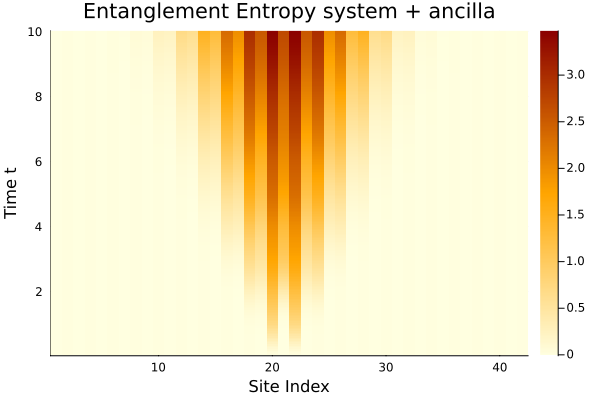

In [45]:
# Plot the entanglement entropy of each bond for system + ancilla:
gr()
heatmap(1:(2*N), times, reduce(vcat,transpose.(SvN)), c = :heat)
ylabel!("Time t")
xlabel!("Site Index")
title!("Entanglement Entropy system + ancilla")

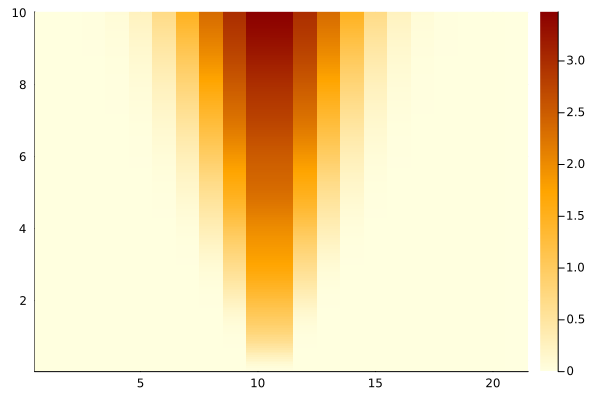

In [46]:
# Plot the entanglement entropy for bonds separating system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,2:2:(2*N)]
heatmap(1:N, times, S, c = :heat)

# a = 1
# sites_arr = range(1,N,step = 1)
# sites_arr = collect(sites_arr)
# v = J*sqrt(1-Δ^2)
# time_arr = collect(LinRange(0,T, N))
# x_τ = a.*(sites_arr.-N)/v.*time_arr
# plot!(time_arr, x_τ)

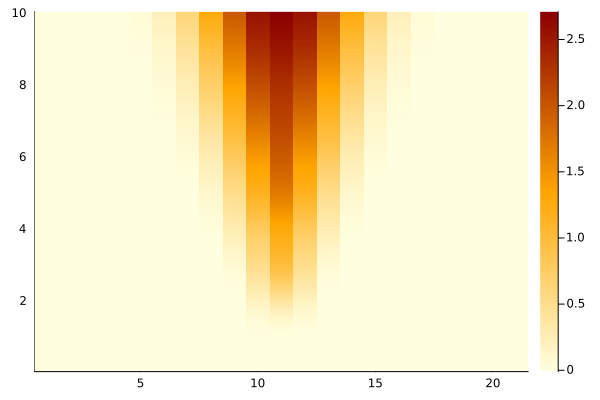

In [47]:
# Plot entanglement entropy of bonds between system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,1:2:(2*N)]
heatmap(1:N, times, S, c = :heat)

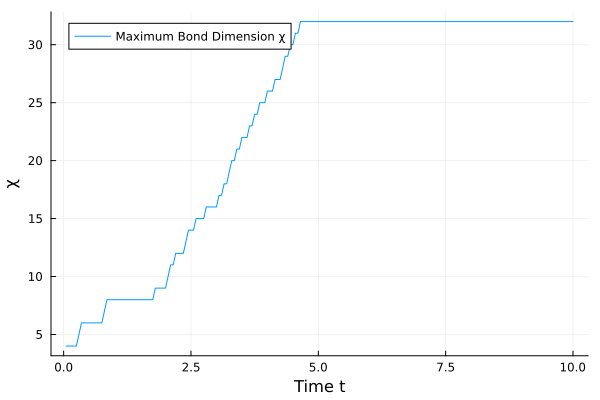

In [48]:
# Plot the growth in the maximum link dimension with time:
plot(times, chi, label="Maximum Bond Dimension χ",framstyle=:box,legend=:topleft)  
#scatter!(times, chi, label=false) 

xlabel!("Time t")
ylabel!("χ")

In [49]:
# function calculate_inner_product(Commutator_array, N)
#     #inner_product_array_5 = []
#     inner_product_array_10 = []

#     for entry in Commutator_array
        
#         #inner_product_5 = inner(entry[1], entry[1])
#         #push!(inner_product_array_5, inner_product_5)

#         inner_product_10 = inner(entry, entry) # add entry[2]
#         push!(inner_product_array_10, inner_product_10)
#     end
#     return inner_product_array_10 
# end

#Commutator is array of [real.(inner(commutator_2, commutator_2)), real.(inner(commutator_4, commutator_4)),
#                           real.(inner(commutator_6, commutator_6)), real.(inner(commutator_8, commutator_8))]
# # per timestep
C_r_t_2 = []
C_r_t_4 = []
C_r_t_6 = []
C_r_t_8 = []
for line in Commutator

    c_2 = (1/(2^N)) * line[1]
    c_4 = (1/(2^N)) * line[2]
    c_6 = (1/(2^N)) * line[3]
    c_8 = (1/(2^N)) * line[4]

    push!(C_r_t_2, c_2)
    push!(C_r_t_4, c_4)
    push!(C_r_t_6, c_6)
    push!(C_r_t_8, c_8)
end;
#C_r_t_10= (1/(2^N))*Commutator_inner_product_10



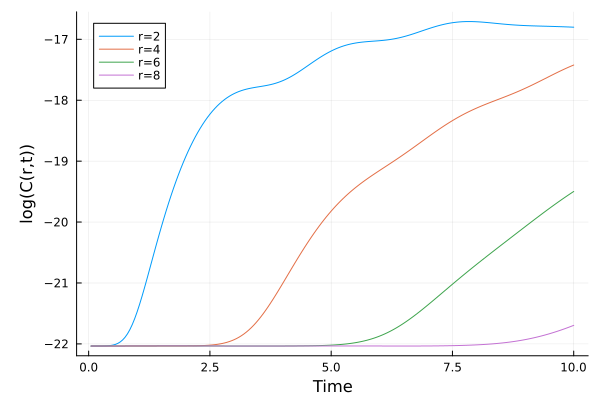

In [56]:
using Plots.PlotMeasures
min_y = -70

plot(times,log.(C_r_t_2), label="r=2", left_margin=20px)#left_margin = [5mm 0mm]) # ylim=(min_y, 20)
#scatter!(times,log.(C_r_t_2), ylim=(min_y, 20))
plot!(times,log.(C_r_t_4), label="r=4") #!
#scatter!(times,log.(C_r_t_4), ylim=(min_y, 20))
plot!(times,log.(C_r_t_6), label="r=6")
#scatter!(times,log.(C_r_t_6), ylim=(min_y, 20))
plot!(times,log.(C_r_t_8), label="r=8")
#scatter!(times,log.(C_r_t_8), ylim=(min_y, 20))

xlabel!("Time")
ylabel!("log(C(r,t))")

